In [1]:
import numpy as np

import scipy.ndimage as ndi
from scipy.ndimage._ni_support import _normalize_sequence
from scipy.spatial.distance import cdist
from scipy.interpolate import RBFInterpolator
from scipy.spatial import ConvexHull
import scipy.io as scio
import scipy.sparse as sp
from sklearn.decomposition import PCA
from scipy import stats


import matplotlib

from matplotlib import colors, ticker, gridspec, rc, transforms
from matplotlib.ticker import PercentFormatter, LogFormatter, FuncFormatter, LogLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter, OrderedDict

import os
from importlib import reload

import sys
sys.path.append('/Users/simonfreedman/cqub/bifurc/paper_figs')
import myfun as mf

# setup matplotlib latex use
#matplotlib.use('agg')
rc('text',usetex=True)
rc('text.latex', preamble=r'\usepackage{color}')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'


matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches


#from wordcloud import WordCloud
import time
import re
import glob
import pickle as pkl
from scipy.spatial import Delaunay 
import networkx as nx

In [19]:
# def overlap_digitize(arr, bmin, bmax, dbin, bin_overlap):
    
#     ndigs = dbin / bin_overlap
    
#     bins1 = np.arange(bmin+bin_overlap*0, bmax+dbin, dbin)
#     digs1 = np.digitize(arr, bins)
#     bins2 = np.arange(bmin+bin_overlap*1, bmax+dbin, dbin)
#     digs2 = np.digitize(arr,bins)
#     binsn

def bin_idx_wid(arr, avg_bin_wid, overlap_frac): 

    min_arr    = np.nanmin(arr)
    max_arr    = np.nanmax(arr)
    inc        = avg_bin_wid*(1-overlap_frac)
    bin_left   = np.arange(min_arr, max_arr, inc)
    bin_right  = bin_left + avg_bin_wid 
    return [np.array(np.where((np.isfinite(arr))&(arr>=bin_left[i])&(arr<bin_right[i]))).T 
            for i in range(len(bin_left))]

def bin_idx_inc(arr, bmin, bmax, dbin, inc): 

    min_arr    = np.nanmin(arr)
    max_arr    = np.nanmax(arr)
    bin_left   = np.arange(bmin, bmax, inc)
    bin_right  = bin_left + dbin
    return [np.array(np.where((np.isfinite(arr))&(arr>=bin_left[i])&(arr<bin_right[i]))[0]).T 
            for i in range(len(bin_left))]

def pca_nsamp_evals(t, xbin_idx, ybin_arr_idx, neval = 1):
    xmeans = np.array([np.mean(obs_normd[:,t,cell_bins[ybin_arr_idx][t][xbin_idx][yi]],axis=1) 
                       for yi in range(len(ybins_arr[ybin_arr_idx])) 
                       if cell_bins[ybin_arr_idx][t][xbin_idx][yi].shape[0]>0])
    
#     xmeans = np.array([np.mean(obs_x_normd[t][xbin_idx][cell_bins_xi[ybin_arr_idx][t][xbin_idx][yi]],axis=0) 
#                        for yi in range(len(ybins_arr[ybin_arr_idx])) 
#                        if cell_bins_xi[ybin_arr_idx][t][xbin_idx][yi].shape[0]>0])
    
    #xmeans = xmeans/np.linalg.norm(xmeans,axis=0)
    #print(xmeans.shape)
    nsamp = len(xmeans)
    if nsamp >= neval+1:
        return np.hstack([nsamp, PCA().fit(xmeans).explained_variance_[0:neval]])
    else:
        return np.hstack([nsamp, np.nan+np.zeros(neval)])
    
    
def pca_evals(t, xbin, neval = 1):
    xmeans = np.array([np.mean(obs_full[:,t,cell_bins[t][xbin][yi]],axis=1) for yi in range(len(ybins)) 
          if cell_bins[t][xbin][yi].shape[0]>0])
    if len(xmeans) >= neval+1:
        return PCA().fit(xmeans).explained_variance_[0:neval]
    else:
        return np.nan+np.zeros(neval)
    
def pca_ns_evals(t, xbin_idx, ybin_arr_idx, neval = 1):
     
    xmeans = np.array([np.mean(obs_normd[:,t,cell_bins[ybin_arr_idx][t][xbin_idx][yi]],axis=1) 
                       for yi in range(len(cell_ybins_bsz[ybin_arr_idx])) 
                       if cell_bins[ybin_arr_idx][t][xbin_idx][yi].shape[0]>0])
    
    nsamp = len(xmeans)
    if nsamp >= neval+1:
        return np.hstack([nsamp, PCA().fit(xmeans).explained_variance_[0:neval]])
    else:
        return np.hstack([nsamp, np.nan+np.zeros(neval)])

In [140]:
# load cell data
headdir = '/Users/simonfreedman/'
datdir  = '{0}/data/droso/ommatidia_data/wildtype2/obs'.format(headdir)

xdist_mu  = np.load('{0}/xdist_mu.npy'.format(datdir))
ydist_mu  = np.load('{0}/ydist_mu.npy'.format(datdir))
xdist_std = np.load('{0}/xdist_std.npy'.format(datdir))
ydist_std = np.load('{0}/ydist_std.npy'.format(datdir))

npix      = np.load('{0}/npix.npy'.format(datdir))
ecad_tot  = np.load('{0}/ecad_tot.npy'.format(datdir))

pos_mu    = np.load('{0}/cell_ctr.npy'.format(datdir))

f = open('{0}/mf_idxs.pkl'.format(datdir), 'rb')   
mf_idxs = pkl.load(f)                 
f.close()

precl_idxs   = np.load('{0}/precluster_idxs.npy'.format(datdir))
cell_pix_idx = np.load('{0}/cell_pixel_idx.npy'.format(datdir))


xdist_mu     = -xdist_mu # reverse so that it goes left to right
aspect_ratio = np.load('{0}/cell_aspect_ratio.npy'.format(datdir))

f = open('{0}/cell_edge_pix.pkl'.format(datdir), 'rb')  
edge_pixels = pkl.load(f)
f.close()


In [145]:
with open('{0}/mf_idxs.pkl'.format(datdir), 'rb') as f: mf_idx = pkl.load(f) 

In [124]:
vx_mf = xdist_mu[1:]-xdist_mu[:1]
vy_mf = ydist_mu[1:]-ydist_mu[:1]

v_lab = pos_mu[1:]-pos_mu[:1]

mf_pos       = np.dstack([xdist_mu, ydist_mu])
nt, ntracks  = vx_mf.shape

precl_idxs_f = precl_idxs.reshape(-1)

In [125]:
obs_full    = np.array([ecad_tot[:nt]/npix[:nt], npix[:nt], vx_mf[:nt], vy_mf[:nt], aspect_ratio[:nt]])
nobs        = obs_full.shape[0]

In [126]:
xlim = np.array([-400,400])
ylim = np.array([-500,500])
xbsz = 20
ybsz = 20
xbins = np.arange(xlim[0], xlim[1]+xbsz, xbsz)

xdist_mu2                  = np.copy(xdist_mu[:-1])
xdist_mu2[np.isnan(vx_mf)] = np.nan

ydist_mu2 = np.copy(ydist_mu[:-1])
ydist_mu2[np.isnan(vy_mf)] = np.nan

xcell_bin = np.digitize(xdist_mu2, xbins) # could generalize with overlapping bins with my own digitize function..
#ycell_bin = np.digitize(ydist_mu2, ybins)

#xy_bin = np.dstack([xcell_bin, ycell_bin])

In [127]:
xi_pre_mf  = np.where(xbins<0)[0]
xi_post_mf = np.where(xbins>=0)[0]

In [128]:
ybsz_arr       = np.hstack([np.arange(1,10), np.arange(10,100,10), np.arange(100,400,100)])
ybins_arr      = [np.arange(ylim[0], ylim[1]+ybsz, ybsz) for ybsz in ybsz_arr]
n_ybins        = np.array(list(map(len, ybins_arr)))
ycell_bin_arr  = [np.digitize(ydist_mu2, ybins) for ybins in ybins_arr]
cells_per_ybin = [[[np.array(np.where(ycell_bin_arr[i][t]==yi)[0]) 
                    for yi in range(n_ybins[i])] 
                   for t in range(nt)] 
                  for i in range(len(ybsz_arr))]

In [129]:
cell_xbins = [[np.array(np.where(xcell_bin[t]==xi)[0]) for xi in range(len(xbins))] for t in range(nt)]
# cell_ybins = [[np.array(np.where(ycell_bin[t]==yi)[0]) for yi in range(len(ybins))] for t in range(nt)]

In [130]:
# cell_bins = [[[np.intersect1d(cell_xbins[t][i], cell_ybins[t][j]) 
#                 for j in range(len(ybins))] 
#                for i in range(len(xbins))]
#               for t in range(nt)]

In [131]:
cell_bins = [[[[np.intersect1d(cell_xbins[t][i], cells_per_ybin[k][t][j]) 
                for j in range(len(ybins_arr[k]))] 
               for i in range(len(xbins))]
              for t in range(nt)]
             for k in range(len(ybsz_arr))]

In [132]:
cells_per_t = [np.where(~np.isnan(vx_mf[t]))[0] for t in np.arange(nt)]

In [133]:
obs_normd.shape

(5, 97, 720)

In [134]:
obs_norms = np.array([np.linalg.norm(obs_full[:,t,cells_per_t[t]],axis=1) for t in range(nt)])
obs_normd = (obs_full.transpose((2,1,0))/obs_norms).transpose((2,1,0)) # shape = [nobs, nt, ncell]
#obs_normd.shape

In [135]:
def xy_bin_pca(xbin_idx, ybin_arr_idx, neval = 1, zsc = False):
    xmeans = np.array([np.mean(obs_normd[:,t,cell_bins[ybin_arr_idx][t][xbin_idx][yi]],axis=1) 
                       for yi in range(len(ybins_arr[ybin_arr_idx])) 
                       for t in range(nt) 
                       if cell_bins[ybin_arr_idx][t][xbin_idx][yi].shape[0]>0])
    
    #print(xmeans.shape)
    #xmeans = xmeans.reshape((-1,5))
    nsamp = len(xmeans)
    if nsamp >= neval+1:
        if zsc:
            xpca = PCA().fit(stats.zscore(xmeans,axis=0))
        else:
            xpca = PCA().fit(xmeans)
        return xpca.explained_variance_[0:neval], xpca.components_[0:neval], nsamp
    else:
        return np.nan+np.zeros(neval), np.nan+np.zeros((neval,obs_normd.shape[0])), nsamp
    

def xyt_bin_pca(t, xbin_idx, ybin_arr_idx, neval = 1, zsc = False):
    xmeans = np.array([np.mean(obs_normd[:,t,cell_bins[ybin_arr_idx][t][xbin_idx][yi]],axis=1) 
                       for yi in range(len(ybins_arr[ybin_arr_idx])) 
                       if cell_bins[ybin_arr_idx][t][xbin_idx][yi].shape[0]>0])
    
    nsamp = len(xmeans)
    if nsamp >= neval+1:
        if zsc:
            xpca = PCA().fit(stats.zscore(xmeans,axis=0))
        else:
            xpca = PCA().fit(xmeans)
        return xpca.explained_variance_[0:neval], xpca.components_[0:neval], nsamp
    else:
        return np.nan+np.zeros(neval), np.nan+np.zeros((neval,obs_normd.shape[0])), nsamp

In [136]:
neval = 1
nsamp_k_x = np.zeros((len(ybsz_arr), len(xbins)))
evals_k_x = np.zeros((len(ybsz_arr), len(xbins), neval))
evecs_k_x = np.zeros((len(ybsz_arr), len(xbins), neval, nobs))

for j in range(len(ybsz_arr)): 
    for i in range(len(xbins)):
        res = xy_bin_pca(i, j, neval, False)
        evals_k_x[j,i] = res[0]
        evecs_k_x[j,i] = res[1]
        nsamp_k_x[j,i] = res[2]

In [137]:
# i=0
# evals_k_x[:,xx_pre[i]]-evals_k_x[0,xx_ppre[i]]

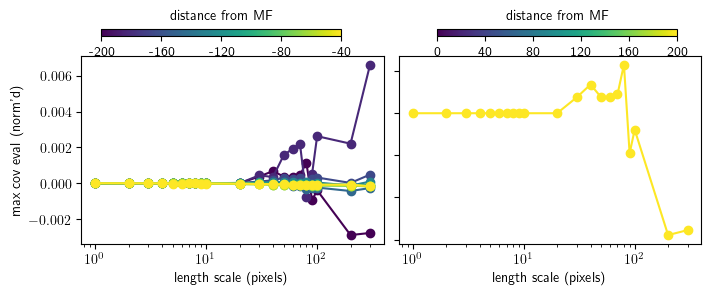

In [138]:
fig,axs=plt.subplots(1,2,figsize=(8,2.5))
xx_pre = np.arange(10,len(xi_pre_mf))
nx   = len(xx_pre)
cols = plt.cm.viridis(np.linspace(0,1,nx))
for i in range(nx):
    axs[0].plot(ybsz_arr, evals_k_x[:,xx_pre[i]]-evals_k_x[0,xx_pre[i]], 'o-', color = cols[i], 
                label=xbins[xi_pre_mf[xx_pre[i]]])
#     axs[0].plot(ybsz_arr, evals_k_x[:,xx_pre[i]], 'o-', color = cols[i], 
#                 label=xbins[xi_pre_mf[xx_pre[i]]])

plt.subplots_adjust(top=0.86)
cax  = plt.axes([0.15, 0.94, 0.3, 0.03])
my_cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
ctix = np.linspace(0,1,5)
cbar.set_ticks(ctix)
cbar.set_ticklabels(xbins[xi_pre_mf[xx_pre[::2]]])
cbar.set_label(r'distance from MF',rotation = 0, labelpad = 7)
cbar.ax.xaxis.set_label_position('top')    

xx_post = np.arange(0,len(xi_post_mf)-10)
nx   = len(xx_post)
cols = plt.cm.viridis(np.linspace(0,1,nx))
my_cmap = plt.cm.viridis

for i in range(nx):
    axs[1].plot(ybsz_arr, evals_k_x[:,xx_post[i]]-evals_k_x[0,xx_post[i]], 'o-', color = cols[i], 
                label=xbins[xi_post_mf[xx_post[i]]])
#     axs[1].plot(ybsz_arr, evals_k_x[:,xx_post[i]], 'o-', color = cols[i], 
#                 label=xbins[xi_post_mf[xx_post[i]]])

cax  = plt.axes([0.57, 0.94, 0.3, 0.03])
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
ctix = np.linspace(0,1,6)
cbar.set_ticks(ctix)
cbar.set_ticklabels(xbins[xi_post_mf[xx_post[::2]]])
cbar.set_label(r'distance from MF',rotation = 0, labelpad = 7)
cbar.ax.xaxis.set_label_position('top')    

for ax in axs:
    ax.set_xscale('log')
    #ax.set_ylim(-9e-4,4e-4)
    #ax.set_xlim(10,450)
    ax.set_xlabel(r'length scale (pixels)')
    #ax.legend()
axs[1].set_yticklabels([])
plt.subplots_adjust(wspace=0.05)

axs[0].set_ylabel('max cov eval (norm\'d)')
#axs.set_yscale('symlog')
#axs.set_xlim(10,400)
plt.show()

In [ ]:
evecs_k_x = np.zeros((len(ybsz_arr), len(xbins), neval, nobs))

In [79]:
evec0_k_x = evecs_k_x[:,:,0]**2
evec_k_x_norm = (evec0_k_x.transpose((1,0,2)) / np.sum(evec0_k_x,axis=1)).transpose((1,0,2))

In [80]:
evec_mu_k_x = np.nanmean(evecs_k_t_x[...,0,:]**2,axis=1)
evec_mu_k_x_norm = (evec_mu_k_x.transpose((1,0,2)) / np.sum(evec_mu_k_x,axis=1)).transpose((1,0,2))

In [82]:
evec_k_x_norm.shape, evec_mu_k_x_norm.shape

((21, 41, 5), (21, 41, 5))

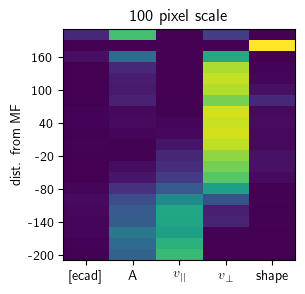

In [86]:
ybsz  = 100
ybsz_i = np.where(ybsz_arr==ybsz)[0][0]

fac = 2
fig,axs=plt.subplots(figsize=(3,3))
xmin_i = int(np.where(xbins==-200)[0])
xmax_i = int(np.where(xbins==200)[0]+1)

xskip = 3
#axs.imshow(evec_mu_k_x_norm[ybsz_i,xmin_i:xmax_i],aspect='auto', origin='lower')
axs.imshow(evec0_k_x[ybsz_i,xmin_i:xmax_i],aspect='auto', origin='lower')

axs.set_yticks(np.arange(0,xmax_i-xmin_i,xskip))
axs.set_yticklabels(xbins[xmin_i:xmax_i:xskip]) 
    
axs.set_xticks(range(5))
axs.set_xticklabels(['[ecad]',r'A',r'$v_{||}$',r'$v_{\perp}$','shape'])
axs.set_title('{0} pixel scale'.format(ybsz))

axs.set_ylabel('dist. from MF')

plt.show()

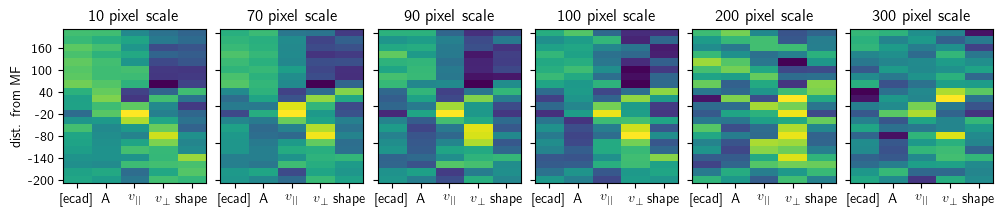

In [64]:
ybszs  = np.array([10,70,90,100,200,300])
ybsz_i = np.intersect1d(ybsz_arr, ybszs, return_indices=True)[1]

fac = 2
fig,axs=plt.subplots(1,len(ybszs), figsize=(fac*len(ybszs), fac))
xmin_i = int(np.where(xbins==-200)[0])
xmax_i = int(np.where(xbins==200)[0]+1)

xskip = 3
for j,yj in enumerate(ybsz_i):
    axs[j].imshow(evec_mu_k_x_norm[yj,xmin_i:xmax_i],aspect='auto', origin='lower')
    if j>0:
        axs[j].set_yticklabels([])
    else:
        axs[j].set_yticks(np.arange(0,xmax_i-xmin_i,xskip))
        axs[j].set_yticklabels(xbins[xmin_i:xmax_i:xskip]) 
    
    axs[j].set_xticks(range(5))
    axs[j].set_xticklabels(['[ecad]',r'A',r'$v_{||}$',r'$v_{\perp}$','shape'])
    axs[j].set_title('{0} pixel scale'.format(ybszs[j]))

axs[0].set_ylabel('dist. from MF')
plt.subplots_adjust(wspace=0.1)

plt.show()

In [49]:
# cell_bins_xi = [[[[np.intersect1d(cell_xbins[t][i], cells_per_ybin[k][t][j], return_indices=True)[1] 
#                 for j in range(len(ybins_arr[k]))] 
#                for i in range(len(xbins))]
#               for t in range(nt)]
#              for k in range(len(ybsz_arr))]

In [50]:
# neval = 1
# nsamp_k_t_x = np.zeros((len(ybsz_arr), nt, len(xbins)))
# evals_k_t_x = np.zeros((len(ybsz_arr), nt, len(xbins), neval))
# evecs_k_t_x = np.zeros((len(ybsz_arr), nt, len(xbins), neval, nobs))

# for j in range(len(ybsz_arr)):
#     for t in range(nt):
#         for i in range(len(xbins)):
#             res = xyt_bin_pca(t, i, j, neval, True)
#             evals_k_t_x[j,t,i] = res[0]
#             evecs_k_t_x[j,t,i] = res[1]
#             nsamp_k_t_x[j,t,i] = res[2]

In [65]:
#evals_k_t_x.shape, evecs_k_t_x.shape

((21, 116, 41, 1), (21, 116, 41, 1, 5))

In [52]:
#mu_eval = np.nanmean(evals_k_t_x[...,0],axis=1)

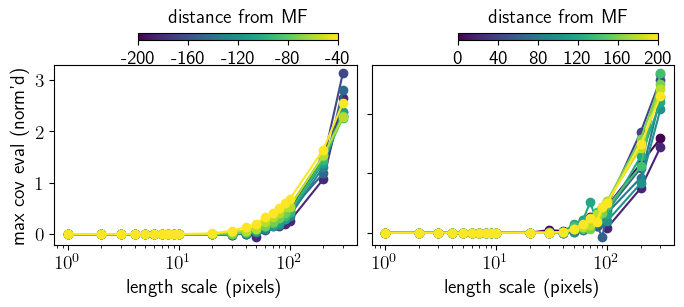

In [53]:
# fig,axs=plt.subplots(1,2,figsize=(8,2.5))
# fsz = 14
# xx_pre = np.arange(10,len(xi_pre_mf))
# nx   = len(xx_pre)
# cols = plt.cm.viridis(np.linspace(0,1,nx))
# for i in range(nx):
#     axs[0].plot(ybsz_arr, mu_eval[:,xx_pre[i]]-mu_eval[0,xx_pre[i]], 'o-', color = cols[i], 
#                 label=xbins[xi_pre_mf[xx_pre[i]]])

# plt.subplots_adjust(top=0.83)
# cax  = plt.axes([0.23, 0.93, 0.25, 0.03])
# my_cmap = plt.cm.viridis
# sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))
# cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
# ctix = np.linspace(0,1,5)
# cbar.set_ticks(ctix)
# cbar.set_ticklabels(xbins[xi_pre_mf[xx_pre[::2]]])
# cbar.set_label(r'distance from MF',rotation = 0, labelpad = 7)
# cbar.ax.xaxis.set_label_position('top')    

# mf.set_axs_fontsize(cax, fsz)


# xx_post = np.arange(0,len(xi_post_mf)-10)
# nx   = len(xx_post)
# cols = plt.cm.viridis(np.linspace(0,1,nx))
# my_cmap = plt.cm.viridis

# for i in range(nx):
#     axs[1].plot(ybsz_arr, mu_eval[:,xx_post[i]]-mu_eval[0,xx_post[i]], 'o-', color = cols[i], 
#                 label=xbins[xi_post_mf[xx_post[i]]])

# cax  = plt.axes([0.63, 0.93, 0.25, 0.03])
# sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))
# cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
# ctix = np.linspace(0,1,6)
# cbar.set_ticks(ctix)
# cbar.set_ticklabels(xbins[xi_post_mf[xx_post[::2]]])
# cbar.set_label(r'distance from MF',rotation = 0, labelpad = 7)
# cbar.ax.xaxis.set_label_position('top')    


# for ax in axs:
#     ax.set_xscale('log')
#     #ax.set_ylim(-9e-4,4e-4)
#     #ax.set_xlim(10,450)
#     ax.set_xlabel(r'length scale (pixels)')
#     #ax.legend()
# axs[1].set_yticklabels([])
# plt.subplots_adjust(wspace=0.05)

# axs[0].ticklabel_format(axis='y', style='sci',scilimits=[-1,1])
# axs[0].yaxis.get_offset_text().set_fontsize(fsz)


# axs[0].set_ylabel('max cov eval (norm\'d)')
# #axs.set_yscale('symlog')
# #axs.set_xlim(10,400)

# mf.set_axs_fontsize(cax, fsz)
# mf.set_axs_fontsize(axs[0], fsz)
# mf.set_axs_fontsize(axs[1], fsz)
# plt.show()

In [75]:
#evec_mu_k_x = np.nanmean(evecs_nsamp_k_x_t[...,0,:]**2,axis=1)

In [5]:
obs_full.shape

(5, 116, 1055)

In [9]:
xlim       = np.array([-400,400])
xbsz       = 20
xbin_left  = np.arange(xlim[0], xlim[1], xbsz)
xbin_right = xbin_left + xbsz
xbins      = np.hstack([xbin_left, xbin_right[-1]])
xbin_ctr   = 0.5*(xbin_left+xbin_right)

In [30]:
xdist_mu2 = np.copy(xdist_mu[:-1])
xdist_mu2[np.isnan(vx_mf)] = np.nan

In [108]:
cell_bins = np.digitize(xdist_mu2, xbins)
cells_per_bin = [np.array(np.where(cell_bins == i)) for i in range(len(xbins))]


In [109]:
precl_idxs_per_bin = [np.intersect1d(cbin[1], precl_idxs_f, return_indices=True)[1] for cbin in cells_per_bin]
precl_per_bin      = [cells_per_bin[i][:,precl_idxs_per_bin[i]] if len(precl_idxs_per_bin[i])>0 else None 
                      for i in range(len(cells_per_bin))]

In [112]:
obs_bin    = [obs_full[:,cbin[0], cbin[1]].T for cbin in cells_per_bin]
obs_bin_pr = [obs_full[:,cbin[0], cbin[1]].T if cbin is not None else None for cbin in precl_per_bin]

In [117]:
obs_bin_norm    = [obin / np.linalg.norm(obin,axis=0) for obin in obs_bin]
obs_bin_pr_norm = [obin / np.linalg.norm(obin,axis=0) if obin is not None else None for obin in obs_bin_pr]

In [46]:
obs_pcas  = [PCA().fit(obin) for obin in obs_bin_norm]
obs_evals = np.array([np.array(obsp.explained_variance_) for obsp in obs_pcas])

In [142]:
obs_bin_pr_norm[20].shape

(62, 5)

In [145]:
obs_pr_pcas  = [PCA().fit(obin) if obin is not None and obin.shape[0]>=2 else None for obin in obs_bin_pr_norm]
obs_pr_eval0 = [obsp.explained_variance_[0] if obsp is not None else np.nan for obsp in obs_pr_pcas]

In [174]:
pr_var = np.array([np.var(obs,axis=0) if obs is not None and len(obs)>=2 else np.nan+np.zeros(nobs) for obs in obs_bin_pr_norm])
pr_mu = np.array([np.mean(obs,axis=0) if obs is not None else np.nan+np.zeros(nobs) for obs in obs_bin_pr_norm])
n_cell = np.array([len(x) if x is not None else 0 for x in precl_per_bin])
pr_std = np.sqrt(pr_var)

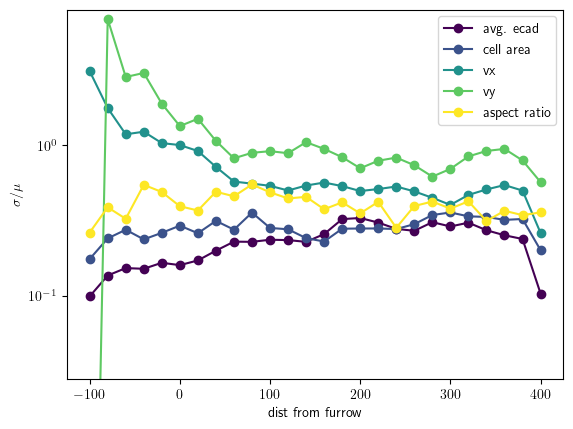

In [181]:
fig,axs=plt.subplots()
cols=plt.cm.viridis(np.linspace(0,1,nobs))
labs = ['avg. ecad', 'cell area','vx','vy','aspect ratio']
for i in range(nobs):
    axs.plot(xbins, pr_std[:,i]/pr_mu[:,i], color=cols[i], label=labs[i], marker='o')
axs.legend()
axs.set_ylabel(r'$\sigma/\mu$')
axs.set_xlabel('dist from furrow')
axs.set_yscale('symlog',linthresh=1e-1)
axs.set_ylim(5e-2, 8)
plt.show()


In [ ]:
obs_pr_eval0 = [obsp.explained_variance_[0] if obsp is not None else np.nan for obsp in obs_pr_pcas]

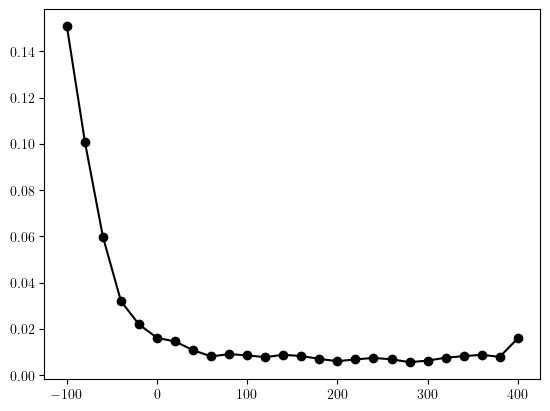

In [151]:
fig,axs=plt.subplots()
axs.plot(xbins,obs_pr_eval0, 'ko-')
plt.show()

In [148]:
fig,axs=plt.subplots()
cols = plt.cm.viridis(np.linspace(0,1,2))
for i in range(1):
    axs.plot(xbins,obs_pr_eval0[:,i], color=cols[i])
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [570]:
#obs_full[:,cells_per_bin[0][0],cells_per_bin[0][1]].shape, len(cells_per_bin[0][0])

In [572]:
# cell_bins = [[[np.array(np.where((xcell_bin[t]==xi)&(ycell_bin[t]==yi))[0]) 
#                for yi in range(len(ybins))] 
#               for xi in range(len(xbins))]
#              for t in range(nt)]

In [579]:
t = 0
xbin = 0
obs_x       = [[obs_full[:,t,cell_xbins[t][xbin]] for xbin in range(len(xbins))] for t in range(nt)]
obs_x_normd = [[obs_x[t][x].T / np.linalg.norm(obs_x[t][x], axis=1) for x in range(len(xbins))] for t in range(nt)]

In [580]:
#obs_full[np.isreal(obs_full[:,0])]

In [581]:
#np.linalg.norm(obs_full[np.isreal(obs_full[:,0]),0],axis=1,where=np.isreal(obs_full[:,0]))

In [647]:
obs_normd.shape

(5, 116, 1055)

In [737]:
ybin_arr_idx = int(np.where(ybsz_arr==100)[0])
#yi = 0
t = 20
xbin_idx = int(np.where(xbins==200)[0])#int(len(xbins)/2)
#obs_x_normd[t][xbin_idx][cell_bins_xi[ybin_arr_idx][t][xbin_idx][yi]]
#yi = 1
obs_x_t_y = obs_x_normd[t][xbin_idx][cell_bins_xi[ybin_arr_idx][t][xbin_idx][yi]]

# [np.mean(obs_x_normd[t][xbin_idx][cell_bins_xi[ybin_arr_idx][t][xbin_idx][yi]],axis=1) 
#                        for yi in range(len(ybins_arr[ybin_arr_idx])) 
#                        if cell_bins_xi[ybin_arr_idx][t][xbin_idx][yi].shape[0]>0]

# xmeans = np.array([np.mean(obs_normd[:,t,cell_bins[ybin_arr_idx][t][xbin_idx][yi]],axis=1) 
#                        for yi in range(len(ybins_arr[ybin_arr_idx])) 
#                        if cell_bins[ybin_arr_idx][t][xbin_idx][yi].shape[0]>0])
# xmeans.shape
obs_x_t_y

array([[0.44647424, 0.09164228, 0.30177924, 0.20171671, 0.0792878 ],
       [0.38097392, 0.12818901, 0.29625992, 0.26833315, 0.18526799]])

In [714]:
obs_x_t_y_norm = np.linalg.norm(obs_x_t_y,axis=0)

In [741]:
obs_x_t_y_z = stats.zscore(obs_x_t_y, axis=0)

In [739]:
(obs_x_t_y-np.mean(obs_x_t_y,axis=0))/np.std(obs_x_t_y,axis=0,ddof=0)

array([[ 1., -1.,  1., -1., -1.],
       [-1.,  1., -1.,  1.,  1.]])

In [ ]:
obs_x_t_y_zsc = obs_x_t_y_

In [742]:
PCA().fit(obs_x_t_y_z).components_[0]

array([ 0.4472136, -0.4472136,  0.4472136, -0.4472136, -0.4472136])

In [716]:
PCA().fit(obs_x_t_y/obs_x_t_y_norm).components_[0]

array([-0.18047671,  0.37507118, -0.02110632,  0.32091814,  0.85047977])

In [584]:
pca_nsamp_evals(0,20,13)

array([2.00000000e+01, 1.72892928e-04])

In [585]:
evals_nsamp_k_x_t = np.array([[[pca_nsamp_evals(t, i, j) 
                 for i in range(len(xbins))] 
                for t in range(nt)] 
               for j in range(len(ybsz_arr))]) 

In [653]:
evecs_nsamp_k_x_t = np.array([[[pca_nsamp_evec(t, i, j) 
                 for i in range(len(xbins))] 
                for t in range(nt)] 
               for j in range(len(ybsz_arr))]) # shouldn't have put nsamp in name

In [655]:
evecs_nsamp_k_x_t.shape # i = length scale index
                        # j = time
                        # k = xbin
                        # l = neval
                        # m = observable


(21, 116, 41, 1, 5)

In [671]:
ybsz_i, xmin_i, xmax_i, j,yj

(array([13, 15, 17, 18, 19, 20]), array([10]), array([31]), 0, 13)

In [771]:
#evec_mu_k_x[int(yj),int(xmin_i):int(xmax_i)]

In [592]:
#evals_nsamp_k_x_t.shape

In [587]:
# nsamp_k_x_t = np.array([[[pca_evals(t, i, j)[0] 
#                  for i in range(len(xbins))] 
#                 for t in range(nt)]
#                for j in range(len(ybsz_arr))]) 

In [593]:
#np.mean(np.mean(evals_nsamp_k_x_t[...,0],axis=1),axis=0).shape

In [594]:
#evals_nsamp_k_x_t.shape

In [819]:
eval0_k_x_t = evals_nsamp_k_x_t[...,1]
mu_eval = np.nanmean(eval0_k_x_t,axis=1)
mu_eval.shape

(21, 41)

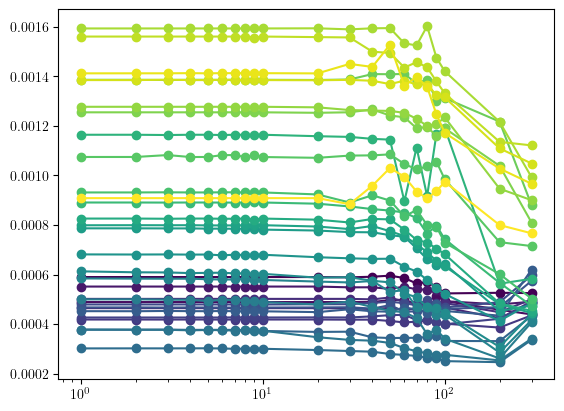

In [595]:
fig,axs=plt.subplots()
xxs = np.arange(9,len(xbins))
nx = len(xxs)
cols = plt.cm.viridis(np.linspace(0,1,nx))
for i in range(nx):
    axs.plot(ybsz_arr, mu_eval[:,xxs[i]], 'o-', color = cols[i])
    #axs.plot(ybsz_arr, mu_eval[:,xxs[i]]/np.mean(evals_nsamp_k_x_t[:,:,xxs[i],0]), 'o-', color = cols[i])

    #axs.plot(ybsz_arr, mu_eval[:,i]-np.mean(mu_eval[0,i]), 'o-', color = cols[i])

axs.set_xscale('log')
#axs.set_yscale('symlog')
#axs.set_xlim(10,400)
plt.show()

In [621]:
xx_pre[::2]

array([10, 12, 14, 16, 18])

In [629]:
xx_post[::2]

array([ 0,  2,  4,  6,  8, 10])

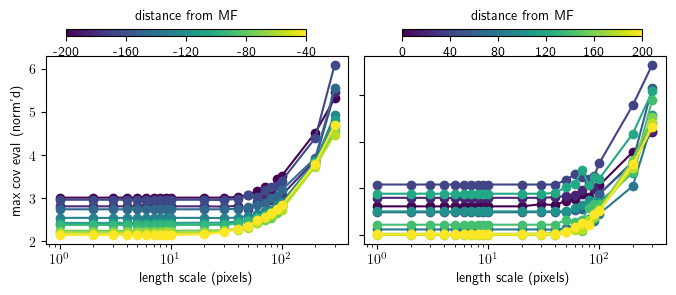

In [770]:
fig,axs=plt.subplots(1,2,figsize=(8,2.5))
xx_pre = np.arange(10,len(xi_pre_mf))
nx   = len(xx_pre)
cols = plt.cm.viridis(np.linspace(0,1,nx))
for i in range(nx):
#     axs[0].plot(ybsz_arr, mu_eval[:,xx_pre[i]]-mu_eval[0,xx_pre[i]], 'o-', color = cols[i], 
#                 label=xbins[xi_pre_mf[xx_pre[i]]])
    axs[0].plot(ybsz_arr, mu_eval[:,xx_pre[i]], 'o-', color = cols[i], 
                label=xbins[xi_pre_mf[xx_pre[i]]])

plt.subplots_adjust(top=0.86)
cax  = plt.axes([0.15, 0.94, 0.3, 0.03])
my_cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
ctix = np.linspace(0,1,5)
cbar.set_ticks(ctix)
cbar.set_ticklabels(xbins[xi_pre_mf[xx_pre[::2]]])
cbar.set_label(r'distance from MF',rotation = 0, labelpad = 7)
cbar.ax.xaxis.set_label_position('top')    

xx_post = np.arange(0,len(xi_post_mf)-10)
nx   = len(xx_post)
cols = plt.cm.viridis(np.linspace(0,1,nx))
my_cmap = plt.cm.viridis

for i in range(nx):
#     axs[1].plot(ybsz_arr, mu_eval[:,xx_post[i]]-mu_eval[0,xx_post[i]], 'o-', color = cols[i], 
#                 label=xbins[xi_post_mf[xx_post[i]]])
    axs[1].plot(ybsz_arr, mu_eval[:,xx_post[i]], 'o-', color = cols[i], 
                label=xbins[xi_post_mf[xx_post[i]]])

cax  = plt.axes([0.57, 0.94, 0.3, 0.03])
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
ctix = np.linspace(0,1,6)
cbar.set_ticks(ctix)
cbar.set_ticklabels(xbins[xi_post_mf[xx_post[::2]]])
cbar.set_label(r'distance from MF',rotation = 0, labelpad = 7)
cbar.ax.xaxis.set_label_position('top')    

for ax in axs:
    ax.set_xscale('log')
    #ax.set_ylim(-9e-4,4e-4)
    #ax.set_xlim(10,450)
    ax.set_xlabel(r'length scale (pixels)')
    #ax.legend()
axs[1].set_yticklabels([])
plt.subplots_adjust(wspace=0.05)

axs[0].set_ylabel('max cov eval (norm\'d)')
#axs.set_yscale('symlog')
#axs.set_xlim(10,400)
plt.show()

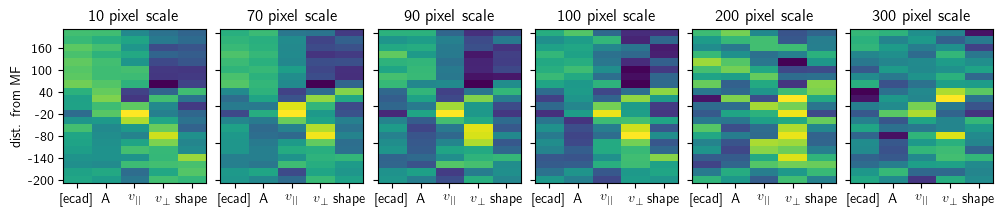

In [777]:
ybszs  = np.array([10,70,90,100,200,300])
ybsz_i = np.intersect1d(ybsz_arr, ybszs, return_indices=True)[1]

fac = 2
fig,axs=plt.subplots(1,len(ybszs), figsize=(fac*len(ybszs), fac))
xmin_i = int(np.where(xbins==-200)[0])
xmax_i = int(np.where(xbins==200)[0]+1)

xskip = 3
for j,yj in enumerate(ybsz_i):
    axs[j].imshow(evec_mu_k_x_norm[yj,xmin_i:xmax_i],aspect='auto', origin='lower')
    if j>0:
        axs[j].set_yticklabels([])
    else:
        axs[j].set_yticks(np.arange(0,xmax_i-xmin_i,xskip))
        axs[j].set_yticklabels(xbins[xmin_i:xmax_i:xskip]) 
    
    axs[j].set_xticks(range(5))
    axs[j].set_xticklabels(['[ecad]',r'A',r'$v_{||}$',r'$v_{\perp}$','shape'])
    axs[j].set_title('{0} pixel scale'.format(ybszs[j]))

axs[0].set_ylabel('dist. from MF')
plt.subplots_adjust(wspace=0.1)

plt.show()

In [815]:
evec0_k_x = evecs_k_x[:,:,0]**2
evec_k_x_norm = (evec0_k_x.transpose((1,0,2)) / np.sum(evec0_k_x,axis=1)).transpose((1,0,2))

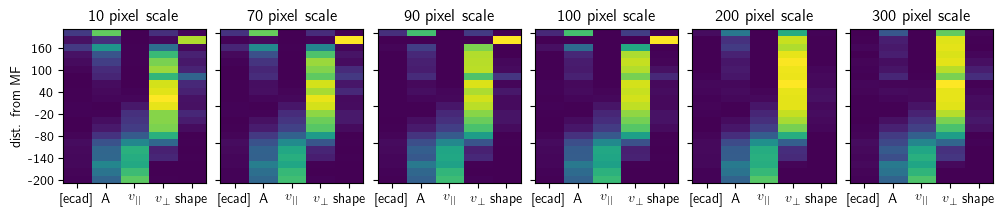

In [817]:
ybszs  = np.array([10,70,90,100,200,300])
ybsz_i = np.intersect1d(ybsz_arr, ybszs, return_indices=True)[1]

fac = 2
fig,axs=plt.subplots(1,len(ybszs), figsize=(fac*len(ybszs), fac))
xmin_i = int(np.where(xbins==-200)[0])
xmax_i = int(np.where(xbins==200)[0]+1)

xskip = 3
for j,yj in enumerate(ybsz_i):
    axs[j].imshow(evec0_k_x[yj,xmin_i:xmax_i],aspect='auto', origin='lower')
    #axs[j].imshow(evec_k_x_norm[yj,xmin_i:xmax_i],aspect='auto', origin='lower')

    if j>0:
        axs[j].set_yticklabels([])
    else:
        axs[j].set_yticks(np.arange(0,xmax_i-xmin_i,xskip))
        axs[j].set_yticklabels(xbins[xmin_i:xmax_i:xskip]) 
    
    axs[j].set_xticks(range(5))
    axs[j].set_xticklabels(['[ecad]',r'A',r'$v_{||}$',r'$v_{\perp}$','shape'])
    axs[j].set_title('{0} pixel scale'.format(ybszs[j]))

axs[0].set_ylabel('dist. from MF')
plt.subplots_adjust(wspace=0.1)

plt.show()

In [ ]:
fig,axs=pl

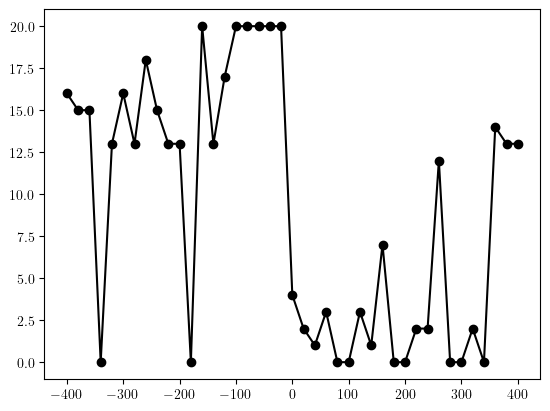

In [471]:
fig,axs=plt.subplots()
axs.plot(xbins, np.argmax(mu_eval-np.amin(mu_eval,axis=0),axis=0),'ko-')
plt.show()

In [293]:
t=50
i=20
j=24
cell_bins2[t][i][j], cell_bins[t][i][j]

(array([481]), array([481]))

In [291]:
xcell_bin[t,np.array([48,165])],ycell_bin[t,np.array([48,165])]

(array([20, 20]), array([ 1, 13]))

In [257]:
evals_x_t = np.array([[pca_evals(t, xbin) for xbin in np.arange(len(xbins))] for t in range(nt)])

In [263]:
evals_x_t[:,:,0].shape

(116, 41)

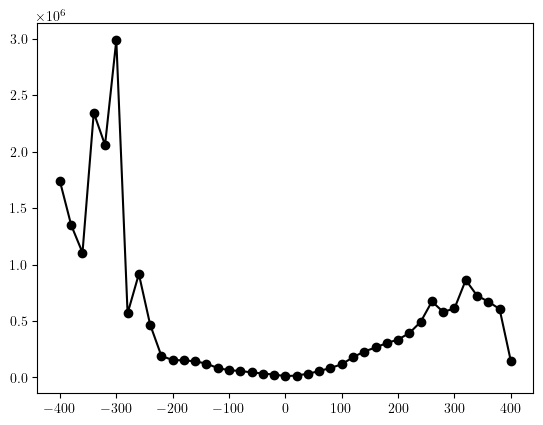

In [268]:
fig,axs=plt.subplots()
axs.plot(xbins,np.nanmean(evals_x_t[:,:,0],axis=0),'ko-')
plt.show()

In [523]:
xlim = np.array([-400,400])
xbsz = 20
xinc = 10
cell_xbins = [bin_idx_inc(xdist_mu2[t], xlim[0], xlim[1], xbsz,xinc) for t in range(nt)]

In [528]:
ylim           = np.array([-500,500])
ybsz_arr       = np.hstack([np.arange(2,10), np.arange(10,100,10), np.arange(100,400,100)])
cell_ybins_bsz = [[bin_idx_inc(ydist_mu2[t], ylim[0], ylim[1], ybsz,int(ybsz/2)) 
                   for t in range(nt)]
                  for ybsz in ybsz_arr]

In [531]:
cell_bins = [[[[np.intersect1d(cell_xbins[t][i], cell_ybins_bsz[k][t][j]) 
                for j in range(len(cell_ybins_bsz[k][t]))] 
               for i in range(len(cell_xbins[t]))]
              for t in range(nt)]
             for k in range(len(ybsz_arr))]

In [546]:
len(cell_bins[0][0])

80

In [544]:
len(cell_xbins[0]), evals_nsamp_k_x_t.shape

(80, (21, 116, 41, 2))

In [549]:
t = 0
xbin_idx = 0
ybin_arr_idx = 0
#pca_ns_evals(t, i, j) 
np.array([np.mean(obs_normd[:,t,cell_bins[ybin_arr_idx][t][xbin_idx][yi]],axis=1) 
                       for yi in range(len(cell_ybins_bsz[ybin_arr_idx])) 
                       if cell_bins[ybin_arr_idx][t][xbin_idx][yi].shape[0]>0])

array([[ 0.01879706,  0.08169006,  0.03789287, -0.03326315,  0.04251955],
       [ 0.01879706,  0.08169006,  0.03789287, -0.03326315,  0.04251955]])

In [535]:
evals_nsamp_k_x_t = np.array([[[pca_ns_evals(t, i, j) 
                 for i in range(len(cell_xbins[t]))] 
                for t in range(nt)] 
               for j in range(len(ybsz_arr))]) 

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/simonfreedman/opt/anaconda3/envs/ml4/lib/python3.8/site-packages/sklearn/decomposition/_p

IndexError: list index out of range

In [536]:
eval0_k_x_t = evals_nsamp_k_x_t[...,1]
mu_eval = np.nanmean(eval0_k_x_t,axis=1)

In [541]:
len(ybsz_arr), mu_eval.shape

(20, (21, 41))

In [538]:
fig,axs=plt.subplots()
xxs = np.arange(9,len(cell_xbins[0]))
nx = len(xxs)
cols = plt.cm.viridis(np.linspace(0,1,nx))
for i in range(nx):
    axs.plot(ybsz_arr, mu_eval[:,xxs[i]], 'o-', color = cols[i])
    #axs.plot(ybsz_arr, mu_eval[:,xxs[i]]/np.mean(evals_nsamp_k_x_t[:,:,xxs[i],0]), 'o-', color = cols[i])

    #axs.plot(ybsz_arr, mu_eval[:,i]-np.mean(mu_eval[0,i]), 'o-', color = cols[i])

axs.set_xscale('log')
#axs.set_yscale('symlog')
#axs.set_xlim(10,400)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (20,) and (21,)